# Introduction

## Background
The dataset consists of many different types of macromolecules of biological signifiance. The majority of the data records are of proteins. With DNA being the precursor to RNA, which when translated, proteins are the biomolecules that are directly interacting in biological pathways and cycles. Proteins are usually centered around one or a few job which is defined by their family type. For example, we can have a protein that is from a Hydrolase group, which focuses on catalyzing hydrolysis (breaking bonds by adding water) in order to help promote destruction of chains of proteins, or other molecules. Another example would be a protein that is a transport protein, which allows other molecules such as sucrose, fructose, or even water come in and outside of the cell. 

## Goals
With these proteins having different family types, a question arises if it's possible to determine a protein's family type based on sequence. There are notable search engines such as BLAST which has this capability, but it'd be interesting to see if a machine learning approach can do a good job in classifying a protein's family based on the protein sequence.

### 1). Import Dataset
To begin, the libraries and datasets are loaded. Since the sequence is of a type string, this appears to be a good opporunity to try using a CountVectorizer -- a feature extractor that is usually used with NLP machine learning models.

In [1]:
# 1). ----- Import Libraries and Datasets ------

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Import Datasets
df_seq = pd.read_csv('pdb_data_seq.csv')
df_char = pd.read_csv('pdb_data_no_dups.csv')

print('Datasets have been loaded...')

Datasets have been loaded...


In [2]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### 2) Filter and Process Data
With the data loaded into two seperate pandas dataframes, a filter, project, and a join must be performed to get the data together. A good library here to check out is the dfply, which is similar to the dplyr library from R. Nevertheless, pandas offers a way to perform these SQL-like commands. Begin by first filtering the datasets where the classification is equal to 'Protein', followed by removing all other variables  other than structureId and sequence for the data_seq_csv, and structureId and classification in the no_dups dataset.

In [3]:
# 2). ----- Filter and Process Dataset ------

# Filter for only proteins
protein_char = df_char[df_char.macromoleculeType == 'Protein']
protein_seq = df_seq[df_seq.macromoleculeType == 'Protein']

# Select only necessary variables to join
protein_char = protein_char[['structureId','classification']]
protein_seq = protein_seq[['structureId','sequence']]
protein_seq.head()


,structureId,sequence
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [4]:
# Filter for only proteins
protein_char = df_char[df_char.macromoleculeType == 'Protein']
protein_seq = df_seq[df_seq.macromoleculeType == 'Protein']
# add resolution as parameter 
protein_char = protein_char[['structureId','classification','resolution']]
protein_seq = protein_seq[['structureId','sequence']]
protein_seq.head()

,structureId,sequence
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [5]:
protein_char.head()

,structureId,classification,resolution
2,101M,OXYGEN TRANSPORT,2.07
4,102L,HYDROLASE(O-GLYCOSYL),1.74
5,102M,OXYGEN TRANSPORT,1.84
7,103L,HYDROLASE(O-GLYCOSYL),1.90
8,103M,OXYGEN TRANSPORT,2.07


The protein_seq correctly contains proteins as different sequences start with Methoinine, as well as sequences containing more letters than 'ACTG'. We can now perform a join using structureId as the index. We'll utilize pandas 'join' method. To do this, we have to set the index for each dataframe to be 'structureId'. 

In [6]:
# Join two datasets on structureId
model_f = protein_char.set_index('structureId').join(protein_seq.set_index('structureId'))
model_f.head()

,classification,resolution,sequence
structureId,,,
101M,OXYGEN TRANSPORT,2.07,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102L,HYDROLASE(O-GLYCOSYL),1.74,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
102M,OXYGEN TRANSPORT,1.84,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
103L,HYDROLASE(O-GLYCOSYL),1.90,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
103M,OXYGEN TRANSPORT,2.07,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [7]:
print('%d is the number of rows in the joined dataset' %model_f.shape[0])

346325 is the number of rows in the joined dataset


The two dataframes have officially been joined into one with 346,325 proteins. The data processing is not finished as it's important to take a look at the misingness associated with the columns.

In [8]:
# Check NA counts
model_f.isnull().sum()

classification        1
resolution        16093
sequence              3
dtype: int64

In [9]:
# Drop rows with missing values and filtered the protein of resolution less than 2.0 
model_f = model_f.dropna()
filtered_proteins = model_f[model_f['resolution'] < 2.0]
print(filtered_proteins.describe())
print('%d is the number of proteins that have a classification and sequence' %filtered_proteins.shape[0])

         resolution
count  99721.000000
mean       1.693001
std        0.225696
min        0.480000
25%        1.570000
50%        1.750000
75%        1.890000
max        1.990000
99721 is the number of proteins that have a classification and sequence


With 99721 proteins, it appears that simply removing missing values is acceptable.

Lastly, it's important to look at the types of family groups that clasification can be.

HYDROLASE                          16978
OXIDOREDUCTASE                     12323
TRANSFERASE                        10679
LYASE                               4768
IMMUNE SYSTEM                       3514
                                   ...  
TOXIN BINDING PROTEIN                  1
Oxidoreductase, hydrolase              1
SIGNALING PROTEIN/APOPTOSIS            1
SIGNALING PROTEIN, FLAVOPROTEIN        1
Actin-BINDING PROTEIN                  1
Name: classification, Length: 1868, dtype: int64


/scratch/local/62343548/ipykernel_128512/2214054678.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(counts, hist = False, color = 'purple')


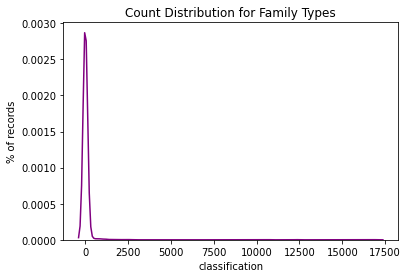

In [10]:
# Look at classification type counts
counts = filtered_proteins.classification.value_counts()
print(counts)

#plot counts
plt.figure()
sns.distplot(counts, hist = False, color = 'purple')
plt.title('Count Distribution for Family Types')
plt.ylabel('% of records')
plt.show()

There appears to be a wide distribution of counts for family types. It may be a good idea to filter for having a certain amount of recordes that are of a specific family type. 1,000 seems like a solid number that will allow a machine learning model to learn a pattern for a specific class.

/scratch/local/62343548/ipykernel_128512/4152186560.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(classification_counts, hist=False, color='purple')


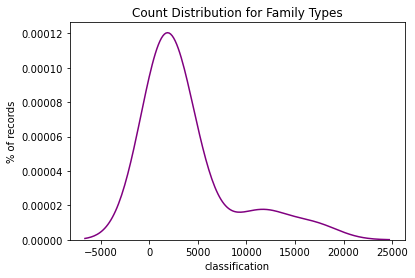

['HYDROLASE' 'OXIDOREDUCTASE' 'TRANSFERASE' 'LYASE' 'IMMUNE SYSTEM'
 'ISOMERASE' 'HYDROLASE/HYDROLASE INHIBITOR' 'TRANSCRIPTION'
 'TRANSPORT PROTEIN' 'SUGAR BINDING PROTEIN' 'SIGNALING PROTEIN'
 'VIRAL PROTEIN' 'PROTEIN BINDING' 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION'
 'UNKNOWN FUNCTION' 'ELECTRON TRANSPORT' 'LIGASE' 'METAL BINDING PROTEIN']
69621 is the number of records in the final filtered dataset


In [11]:
# Get classification types where counts are over 1000
types = np.asarray(counts[(counts > 1000)].index)

# Filter dataset's records for classification types > 1000
data = filtered_proteins[filtered_proteins.classification.isin(types)]

# Count occurrences of each classification type
classification_counts = data.classification.value_counts()

# Plot counts
plt.figure()
sns.distplot(classification_counts, hist=False, color='purple')
plt.title('Count Distribution for Family Types')
plt.ylabel('% of records')
plt.show()

print(types)
print('%d is the number of records in the final filtered dataset' % data.shape[0])



### 3). Train Test Split
After finally filtering the dataset, a split on the data to create a training and testing set must be performed. After splitting the data, it's important to utilize the CountVectorizer to create a dictionary composed from the training dataset. This will extract individual characters or subsets of characters to gain features. An important note about using the CountVectorizer is the specification of the ngram_range. 

In a protein, it's not the individual amino acid in the protein that gives identification to what it's purpose is. There are secondary and tertiary structures that are formed via the bonds of the amino acids in the sequence. Furthermore, different parts of the chain can be more basic, and others can be more acidic, indicating it's important to use features that are larger than just one unit. As a result, using an ngram_range of (4,4) seems to be a legitmate choice for feature extraction. This will extract different subsets that are of length 4 allowing the amino acids to use their neighbors to aid in our classification.

In [12]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['sequence'], data['classification'], test_size=0.2, random_state=1)

# Filter based on resolution
train_res = data[data['sequence'].isin(X_train)]
test_res = data[data['sequence'].isin(X_test)]
train_res = train_res[train_res['resolution'].between(0, 3)]
test_res = test_res[test_res['resolution'].between(0, 3)]

# Filter based on classification types
types = np.asarray(data['classification'].value_counts()[data['classification'].value_counts() > 1000].index)
train_res = train_res[train_res['classification'].isin(types)]
test_res = test_res[test_res['classification'].isin(types)]

# Create CountVectorizer to extract features from sequences
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(analyzer='char_wb', ngram_range=(4,4))

# Fit and transform CountVectorizer on training data
vect.fit(train_res['sequence'])
X_train_df = vect.transform(train_res['sequence'])
X_test_df = vect.transform(test_res['sequence'])

print(vect.get_feature_names_out()[-20:])

['yyy ' 'yyya' 'yyyd' 'yyye' 'yyyf' 'yyyg' 'yyyh' 'yyyi' 'yyyk' 'yyyl'
 'yyym' 'yyyn' 'yyyp' 'yyyq' 'yyyr' 'yyys' 'yyyt' 'yyyv' 'yyyy' 'zhhh']


### 4). Machine Learning Models

With the features extracted, it's time to use machine learning models. Traditionally a Naive Bayes approach works well for these types of count vectorized features. Adaboost will be used as well for comparison.

In [15]:
# Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_df, train_res['classification'])
NB_pred = model.predict(X_test_df)
accuracy = accuracy_score(test_res['classification'], NB_pred)
print("Accuracy of MultinomialNB model:", accuracy)

Accuracy of MultinomialNB model: 0.9036279590979128


###5). Visualize Metrics
It appears that Naive Bayes does better in classification than Adaboost. A visualization of a confusion matrix and a clasification report for the Navie Bayes prediction can aid in where the model performs poorly.

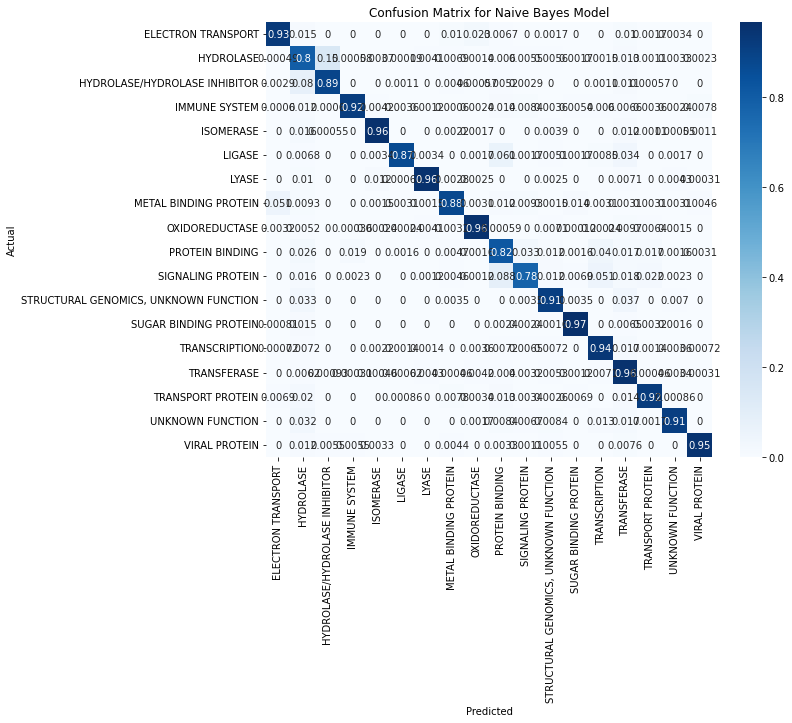

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

types = np.unique(train_res['classification'])
conf_mat = confusion_matrix(test_res['classification'], NB_pred, labels=types)
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=types, yticklabels=types)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix for Naive Bayes Model")
plt.show()

The confusion matrix shows label index 3 being misclassified as index 38 quite a bit. Based on the names listed below, it makes sense for these two to be confused.

Lastly, a matrix of the classification report to show case metrics for each class should be insightful

In [23]:
from sklearn.metrics import classification_report

print(len(test_res['classification']), X_test_df.shape[0])
print(classification_report(test_res['classification'], NB_pred, target_names=types))


42834 42834
                                       precision    recall  f1-score   support

                   ELECTRON TRANSPORT       0.87      0.93      0.90       597
                            HYDROLASE       0.95      0.80      0.87     10280
        HYDROLASE/HYDROLASE INHIBITOR       0.51      0.89      0.65      1741
                        IMMUNE SYSTEM       0.98      0.92      0.95      1674
                            ISOMERASE       0.95      0.96      0.95      1806
                               LIGASE       0.96      0.87      0.91       588
                                LYASE       0.96      0.96      0.96      3219
                METAL BINDING PROTEIN       0.79      0.88      0.83       648
                       OXIDOREDUCTASE       0.99      0.96      0.97      8442
                      PROTEIN BINDING       0.65      0.82      0.73       645
                    SIGNALING PROTEIN       0.82      0.78      0.80       867
STRUCTURAL GENOMICS, UNKNOWN FUNCTION  

### Reasons for Model Error
Proteins in general can be a type of enzyme, or a signaling protein, structural, and various other choices. A lof of proteins tend to share very similar characteristics, as some proteins are meant to bind in similar regions as others. For example, a Hydrolase enzyme and a Hydrolase inhibitor protein are going to have similar structures as they will target very similar areas. This is reflected in the confusion matrix and heat map. Gene regulator proteins will have a similarity to RNA binding proteins, DNA binding proteins, as well as transcription proteins.  The biggest thing to note as well, as the model only uses features of 4 amino acids at most. The possibility of utilizing amino acids of higher degree in theory should be able to create an even higher accuracy.

### Future Work
There is definitely room for improvement for the model. Utilizing factors such as pH, molecular weight, and other components may be able to yield more information on family group. Furthermore, if possible, increase the length of the ngram_range to include more than just 4 characters to allow for higher interaction between the amino acids as reflected in reality

